In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import torch.tensor
from torch.utils.data import random_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import font_manager

In [14]:
def get_ts_dxy(skip_day):
    data = pd.read_csv("https://raw.githubusercontent.com/BlankerL/DXY-COVID-19-Data/master/csv/DXYArea.csv")
    searchfor = ['外地来','明确地区','不明地区','未知地区','未知','人员','待明确']
    data = data[data['countryEnglishName'] == 'China']
    #data = data[~data['cityName'].str.contains('|'.join(searchfor))]
    data = data[~data['provinceName'].str.contains('|'.join(['香港','台湾','澳门']))]
    data = data[data['cityName'].groupby(data['cityName']).transform('size')>40]
    data['updateTime']=pd.to_datetime(data['updateTime']).dt.date
    grouped = data.sort_values('updateTime',ascending = False).groupby(['updateTime'])
    i = 0
    integrate = pd.DataFrame()
    for name,group in grouped:
        i +=1
        set_group = group.drop_duplicates(['provinceName','cityName'])
        set_group = set_group[['provinceName','cityName','city_confirmedCount','city_curedCount','city_deadCount']]
        set_group.rename(columns={"city_confirmedCount": "city_confirmedCount"+' '+str(name), 
                                  "city_curedCount": "city_curedCount"+' '+str(name),
                                  'city_deadCount': 'city_deadCount'+' '+str(name)}, inplace=True)
        if i<=skip_day:
            integrate = set_group
        else:
            integrate = integrate.merge(set_group, how = 'outer', on = ['provinceName','cityName'])
    integrate.dropna(thresh=len(integrate.columns)*0.9, inplace = True)
    integrate['ts']= integrate.iloc[:,2:].values.tolist()
    integrate = integrate[['provinceName','cityName','ts']].reset_index(drop=True)
    return integrate

In [4]:
def prepare_data(data,window):
    '''
    arraydata = []
    for index, row in data.iterrows():
        ts = np.diff(np.reshape(row.ts,(-1,3)),axis = 0)
        ts = ts[~np.isnan(ts).any(axis=1),:]
        address = row.provinceName+row.cityName
        lat, lng = get_location_using_baidu(address)
        for i in range(len(ts)-window+1):
            seq = np.array(ts[i:i+window])
            total_recover = np.sum(seq[:,1])
            total_death = np.sum(seq[:,2])
            seq = seq[:,0] - seq[:,1] - seq[:,2]
            mean = np.mean(seq,axis = 0)
            std = np.std(seq,axis = 0)
            seq -= mean
            if std!=0:
                seq /= std
            final_seq = np.concatenate((seq, [lat, lng, total_recover, total_death, mean, std]))
            arraydata.append(final_seq)
    
    np.savetxt('data.csv', arraydata, delimiter=',')
    '''
    arraydata = np.loadtxt('data.csv', delimiter=',')
    
    arraydata = torch.tensor(arraydata, dtype=torch.float)
    #split or not
    dataset = datasets(arraydata)
    train_len = int(dataset.__len__()*0.8)
    test_len = dataset.__len__()-train_len
    train_data, test_data = random_split(dataset,[train_len,test_len])
    return train_data, test_data

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.fc2 = nn.Linear(output_dim, 1)
        self.relu = nn.PReLU()
        #self.fc3 = nn.Linear(100,1)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, dtype=torch.float).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, dtype=torch.float).requires_grad_()
        out, (hn, cn) = self.lstm(x[:,0:7,:], (h0.detach(), c0.detach()))
        # Index hidden state of last time step
        #out = torch.cat((out[:,-1,:],x[:,11:,0]), dim = 1)
        out = self.fc(out[:,-1,:])
        #out = self.relu(self.fc(out[:, -1, :]))
        #out = torch.cat((out,x[:,7:,0]), dim = 1)
        out = self.fc2(out)
        #out = self.fc3(out)
        return out
    
    
class datasets(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        target = self.data[index][7]
        data_val = torch.cat([self.data[index][0:7], self.data[index][8:]])
        data_val.resize_(13, 1)        
        target.resize_(1)
        return data_val,target

In [6]:
def training_model(train_data, test_data, num_epochs, batch_size=8, input_dim=1, hidden_dim=100, output_dim=100, seq_dim=7):
    
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    Mymodel = LSTMModel(input_dim, hidden_dim, 1, output_dim)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(Mymodel.parameters(), lr=0.0001)
    iters = 0
    hisloss = []
    for epoch in range(num_epochs):
        for data_val,target in train_loader:
            # clean the previous gredient
            optimizer.zero_grad()
            outputs = Mymodel(data_val)
            #calculate loss
            loss = loss_function(outputs, target)
            hisloss.append(loss.item())
            # using loss to calculate gredient, stored in model
            loss.backward()
            # using gredient to update model parameters
            optimizer.step()
            iters += 1
            if iters % 300 ==0:
                for test_val,test_target in test_loader:
                    test_outputs = Mymodel(test_val)
                    loss2 = loss_function(test_outputs, test_target)
                print('Iteration: {}. TrainLoss: {}. TestLoss: {}'.format(iters, loss.item(), loss2.item()))
                torch.save(Mymodel.state_dict(), 'Trained_model/trained_model_'+ str(iters) + '.pkl')
                
    plt.plot(hisloss)
    plt.xlabel('Iteration')
    plt.ylabel('Training loss')
    plt.title('Traing process')
    plt.grid(True)
    plt.savefig('Trained_model/loss.png')
    return Mymodel

In [21]:
def evaluation(provincename, cityname, modelpath, data):
    #lat, long = get_location_using_baidu(provincename+cityname)
    lat, long = [0,0]
    Mymodel = LSTMModel(1, 100, 1, 100)
    Mymodel.load_state_dict(torch.load(modelpath))
    series = data.loc[(data["provinceName"] == provincename) & (data["cityName"] == cityname), "ts"].values.tolist()
    series = np.reshape(series,(-1,3))
    if np.isnan(series[-1][0]):
        series = series[:-1]
    series[:,0] = series[:,0] - series[:,1] - series[:,2]
    diff_series = np.diff(series,axis = 0)
    n = len(diff_series)
    predict_series = np.array(series[0:7,0:1])
    store_diff = np.array(diff_series[0:7,0:1])

    for i in range(n-6):
        seq = np.array(diff_series[i:i+7])
        total_recover = np.sum(seq[:,1])
        total_death = np.sum(seq[:,2])
        seq = seq[:,0:1]
        mean = np.mean(seq[:,0],axis = 0)
        std = np.std(seq[:,0],axis = 0)
        seq -= mean
        if std!=0:
            seq /= std
        tensor_seq = torch.tensor(seq, dtype=torch.float, requires_grad=False)
        add_seq = torch.tensor([[lat], [long], [total_recover], [total_death], [mean], [std]])
        tensor_seq = torch.cat([tensor_seq,add_seq])
        tensor_seq.resize_(1, 13, 1)
        predictions = np.array(Mymodel(tensor_seq).tolist()[0])
        real_diff = predictions * std + mean
        store_diff = np.append(store_diff,[real_diff],axis = 0)
        if i>n-7:
            diff_series = np.append(diff_series,[[real_diff[0],0,0]],axis = 0)
            predict_series = np.append(predict_series,[np.array(list(map(sum,zip(predict_series[-1],real_diff))))],axis = 0)
        else:
            predict_series = np.append(predict_series,[np.array(list(map(sum,zip(series[i+6][0:1],real_diff))))],axis = 0)
    
    
    return series, predict_series, provincename+cityname, store_diff, diff_series

In [8]:
def draw_plot(origin,pred,title):
    fontP = font_manager.FontProperties()
    fontP.set_family('SimHei')
    fontP.set_size(14)
    
    x1 = origin[:,0]
    x2 = pred[:,0]
    plt.plot(x1, label = "True_value")
    plt.plot(x2, label = "Predicted_value")
    plt.xlabel('Time (days)')
    plt.ylabel('Infections')
    plt.title(title,fontproperties=fontP)
    plt.legend()
    plt.grid(True)
    plt.show()
    return

In [25]:
def generate_predictions(provincename, cityname, modelpath, data, lastn):
    Mymodel = LSTMModel(1, 100, 1, 100)
    Mymodel.load_state_dict(torch.load(modelpath))
    series = data.loc[(data["provinceName"] == provincename) & (data["cityName"] == cityname), "ts"].values.tolist()
    series = np.reshape(series,(-1,3))
    N = len(series)
    if np.isnan(series[-1][0]):
        series = series[:-1]
    series = series[:,0] - series[:,1] - series[:,2]
    remov_seq = series[N-lastn:N]
    series = series[:N-lastn]
    for i in range(N-lastn,N):
        input_seq = series[i-8:i]
        diff_seq = np.diff(input_seq)
        mean = np.mean(diff_seq,axis = 0)
        std = np.std(diff_seq,axis = 0)
        diff_seq -= mean
        if std!=0:
            diff_seq /= std
        tensor_seq = torch.tensor(diff_seq, dtype=torch.float, requires_grad=False)
        add_seq = torch.tensor([0, 0, 0, 0, mean, std])
        tensor_seq = torch.cat([tensor_seq,add_seq])
        tensor_seq.resize_(1, 13, 1)
        predictions = np.array(Mymodel(tensor_seq).tolist()[0])
        real_diff = predictions * std + mean
        series = np.append(series, [series[-1]+real_diff[0]], axis = 0)
    predicted_val = series[N-lastn:N]
    series = series[:N-lastn]
    series = np.append(series, remov_seq, axis = 0)
    return predicted_val, series

In [32]:
def prediction_plot(origin, pred, title):
    plt.plot(origin, label = "True_value")
    lastn = len(pred)
    n = len(origin)
    index = np.arange(n-lastn,n)
    plt.plot(index, pred, label = "Predicted_value")
    plt.xlabel('Time (days)')
    plt.ylabel('Infections')
    plt.title(title+'_'+str(lastn)+'_ahead')
    plt.legend()
    plt.grid(True)
    plt.show()
    results = origin[n-lastn:n]
    average_error = np.mean(np.absolute(results-pred))
    print ("average_error="+str(average_error))
    return

Iteration: 300. TrainLoss: 0.5511717796325684. TestLoss: 0.3467045724391937
Iteration: 600. TrainLoss: 0.08866909891366959. TestLoss: 0.06585557758808136
Iteration: 900. TrainLoss: 0.007658255286514759. TestLoss: 0.0036539118736982346
Iteration: 1200. TrainLoss: 0.004397462587803602. TestLoss: 0.0015182014321908355
Iteration: 1500. TrainLoss: 0.003665744327008724. TestLoss: 0.0009638695046305656
Iteration: 1800. TrainLoss: 0.0018277440685778856. TestLoss: 0.0023386224638670683
Iteration: 2100. TrainLoss: 0.0013447505189105868. TestLoss: 0.0005905271973460913
Iteration: 2400. TrainLoss: 0.0006944742635823786. TestLoss: 0.0007546711713075638
Iteration: 2700. TrainLoss: 0.00036393210757523775. TestLoss: 0.001087011187337339
Iteration: 3000. TrainLoss: 0.0007950076251290739. TestLoss: 0.0016035105800256133
Iteration: 3300. TrainLoss: 0.0002958777185995132. TestLoss: 0.0006970787071622908
Iteration: 3600. TrainLoss: 0.0006294220220297575. TestLoss: 4.779141454491764e-05
Iteration: 3900. Tra

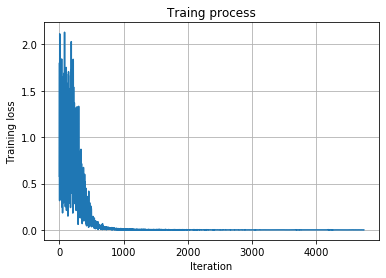

In [15]:
if __name__ == "__main__":
    data = get_ts_dxy(1)
    train,test = prepare_data(data,8)
    Mymodel = training_model(train,test, num_epochs = 6)

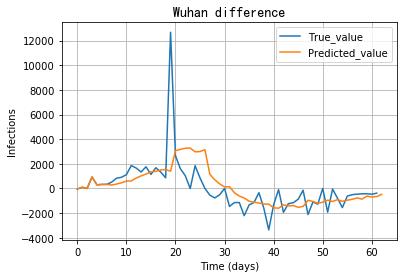

In [22]:
    modelpath = 'Trained_model/trained_model_3300.pkl'
    origin , predictions, title, store_diff, diff_series,  = evaluation('湖北省', '武汉', modelpath, data)
    draw_plot(diff_series, store_diff, 'Wuhan'+' difference')

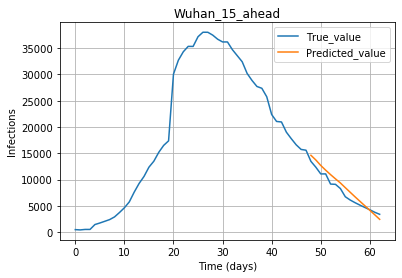

average_error=1040.913390379465


In [33]:
    predicted, rawdata = generate_predictions('湖北省', '武汉', modelpath, data,15)
    prediction_plot(rawdata, predicted, 'Wuhan')